In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import transformers, traitlets
import string, re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from nltk.tokenize import word_tokenize

warnings.simplefilter("ignore")

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [2]:
train = pd.read_csv("../input/student-shopee-code-league-sentiment-analysis/train.csv")
test = pd.read_csv('../input/student-shopee-code-league-sentiment-analysis/test.csv')
train

,review_id,review,rating
0,0,Ga disappointed neat products .. Meletot Hilsn...,1
1,1,"Rdtanya replace broken glass, broken chargernya",1
2,2,Nyesel bngt dsni shopping antecedent photo mes...,1
3,3,Sent a light blue suit goods ga want a refund,1
4,4,Pendants came with dents and scratches on its ...,1
...,...,...,...
146806,146806,Excellent product quality delivery speed is ve...,5
146807,146807,thanks gan,5
146808,146808,Awesome awesome quality merchandise value CP ...,5
146809,146809,Nice Packing boxes made effective price .........,5


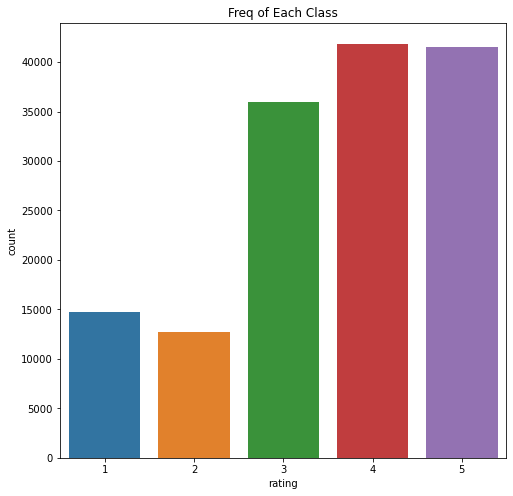

In [3]:
plt.figure(figsize=(8,8))
sns.countplot(train['rating'])
plt.title('Freq of Each Class')
plt.show()

# Preprocess

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit_transform(train['review'])

<146811x60506 sparse matrix of type '<class 'numpy.int64'>'
	with 1742186 stored elements in Compressed Sparse Row format>

In [5]:
words = pd.DataFrame({'words' : list(vectorizer.vocabulary_.keys()), 'Count' : list(vectorizer.vocabulary_.values())})
words = words.sort_values(by='Count', ascending=False)
words[60:80]

,words,Count
48760,이것을,60445
54328,우와,60444
45816,살앙,60443
54257,보라,60442
39528,몬지,60441
54331,대박,60440
39530,너무,60439
48759,나는,60438
39531,귀엽다,60437
48758,고마워,60436


In [6]:
import nltk
nltk.download('punkt')

abbreviations = {
    "gajelas" : "very bad",
    "ga" : "no",
    "gk" : "no",
    "udh" : "already",
    "dteng" : "arrive",
    "lgi" : "again",
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
def preprocess(text):
    # Cleanning unreadable text
    text = ''.join([x for x in text if x in string.printable])
    
    # Cleaning Emoji's
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Remove String Punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Convert Abbrev
    convert_abbrev = lambda word : abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word
    tokens = word_tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    
    return ' '.join([x for x in tokens if len(x) > 1])

In [8]:
preprocess(train['review'][5001])

'Disappointed already long wait even that order Glitter arrive difference that instead arrive masks brand very bad again it hell'

In [9]:
clean_train = np.array(train['review'].apply(preprocess))
clean_test = np.array(test['review'].apply(preprocess))

In [10]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [11]:
def build_model(transformer, loss='categorical_crossentropy', max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    x = tf.keras.layers.Dropout(0.35)(cls_token)
    x = Dense(256, activation='relu')(x)
    out = Dense(5, activation='softmax')(x)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=3e-5), loss=loss, metrics=[tf.keras.metrics.AUC()])
    
    return model

In [12]:
AUTO = tf.data.experimental.AUTOTUNE

# Create strategy from tpu
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [13]:
# First load the real tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

# Save the loaded tokenizer locally
save_path = '/kaggle/working/distilbert_base_uncased/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path)

# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('distilbert_base_uncased/vocab.txt', lowercase=True)
fast_tokenizer

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=True, lowercase=True, wordpieces_prefix=##)

In [14]:
text, label = shuffle(clean_train, train['rating'].to_numpy(), random_state = 123)
text_train, text_valid, y_train, y_valid = train_test_split(text, to_categorical(label - 1), test_size=0.2, random_state = 123)

In [15]:
x_train = fast_encode(text_train, fast_tokenizer, maxlen=512)
x_valid = fast_encode(text_valid, fast_tokenizer, maxlen=512)
x_test = fast_encode(clean_test, fast_tokenizer, maxlen=512)

In [16]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .batch(64)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(64)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(64)
)

In [17]:
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=.2):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [18]:
%%time
with strategy.scope():
    transformer_layer = transformers.TFBertModel.from_pretrained('bert-base-uncased')
    model = build_model(transformer_layer, loss=focal_loss(gamma=1.5), max_len=512)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 512)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  ((None, 512, 768), (None, 109482240 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 768)]             0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               196864    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 109,680,389
Trainable params: 109,680,389
Non-trainable params: 0
______________________________________________

In [19]:
train_history = model.fit(
    train_dataset,
    steps_per_epoch=len(x_train)//64,
    validation_data=valid_dataset,
    epochs=10
)

Epoch 1/10
1835/1835 [==============================] - 398s 217ms/step - auc: 0.8292 - loss: 0.0458 - val_auc: 0.8518 - val_loss: 0.0434
Epoch 2/10
1835/1835 [==============================] - 378s 206ms/step - auc: 0.8593 - loss: 0.0426 - val_auc: 0.8542 - val_loss: 0.0431
Epoch 3/10
1835/1835 [==============================] - 379s 207ms/step - auc: 0.8747 - loss: 0.0407 - val_auc: 0.8478 - val_loss: 0.0443
Epoch 4/10
1835/1835 [==============================] - 382s 208ms/step - auc: 0.8900 - loss: 0.0386 - val_auc: 0.8442 - val_loss: 0.0449
Epoch 5/10
1835/1835 [==============================] - 385s 210ms/step - auc: 0.9038 - loss: 0.0365 - val_auc: 0.8323 - val_loss: 0.0471
Epoch 6/10
1835/1835 [==============================] - 386s 210ms/step - auc: 0.9156 - loss: 0.0344 - val_auc: 0.8256 - val_loss: 0.0517
Epoch 7/10
1835/1835 [==============================] - 384s 209ms/step - auc: 0.9244 - loss: 0.0327 - val_auc: 0.8299 - val_loss: 0.0518
Epoch 8/10
 476/1835 [======>.....

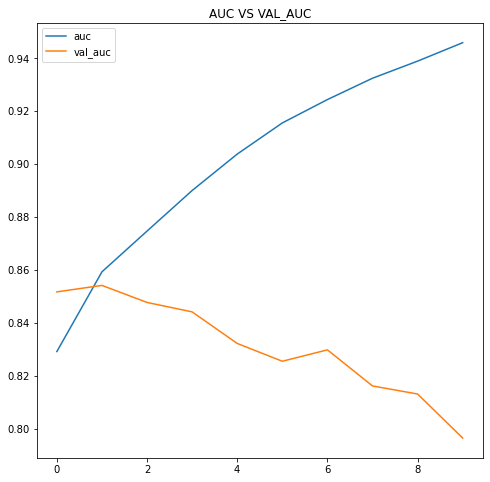

In [20]:
plt.figure(figsize=(8,8))
plt.plot(range(10), train_history.history['auc'], label='auc')
plt.plot(range(10), train_history.history['val_auc'], label='val_auc')
plt.title('AUC VS VAL_AUC')
plt.legend()
plt.show()

In [21]:
pred = model.predict(test_dataset)
res = [np.argmax(x) + 1 for x in pred]
sub = pd.DataFrame({'review_id' : test['review_id'], 'rating' : res})
sub

,review_id,rating
0,1,3
1,2,2
2,3,5
3,4,4
4,5,4
...,...,...
60422,60423,5
60423,60424,2
60424,60425,4
60425,60426,4


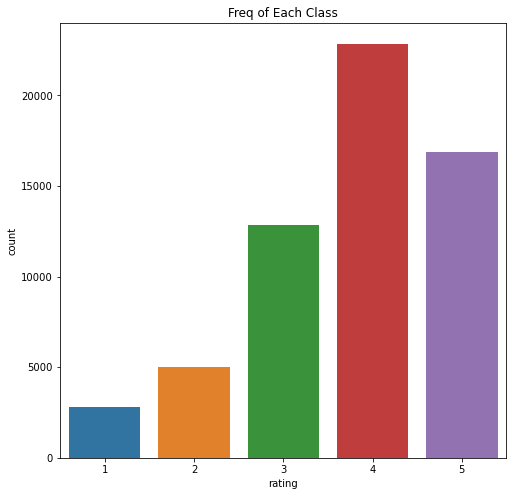

In [22]:
plt.figure(figsize=(8,8))
sns.countplot(sub['rating'])
plt.title('Freq of Each Class')
plt.show()

In [23]:
sub.to_csv('Submission.csv', index=False)